Бизнес-цель:

Кластеризация сделок с акциями инсайдеров для выявления групп с схожими характеристиками торговых операций и взаимосвязями между различными признаками, такими как количество акций, стоимость сделки и цена акции.

### Выгрузка данных из файла в DataFrame:

In [13]:
import pandas as pd
from pandas import DataFrame


df: DataFrame = pd.read_csv("static/csv/TSLA.csv")

Преобразование данных:

In [14]:
# Устранить выборсы в DataFrame
def remove_outliers(dataframe: DataFrame, columns: list[str]) -> DataFrame:
    for column in columns:
        if not pd.api.types.is_numeric_dtype(dataframe[column]): # Проверяем, является ли колонка числовой
            continue
        
        Q1: float = dataframe[column].quantile(0.25) # 1-й квартиль (25%)
        Q3: float = dataframe[column].quantile(0.75) # 3-й квартиль (75%)
        IQR: float = Q3 - Q1 # Вычисляем межквартильный размах

        # Определяем границы для выбросов
        lower_bound: float = Q1 - 1.5 * IQR # Нижняя граница
        upper_bound: float = Q3 + 1.5 * IQR # Верхняя граница

        # Устраняем выбросы:
        # Заменяем значения ниже нижней границы на нижнюю границу
        # А значения выше верхней границы – на верхнюю
        dataframe[column] = dataframe[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
    
    return dataframe


# Преобразование типов данных
df['Insider Trading'] = df['Insider Trading'].astype('category')                             # Преобразование в категорию
df['Relationship'] = df['Relationship'].astype('category')                                   # Преобразование в категорию
df['Transaction'] = df['Transaction'].astype('category')                                     # Преобразование в категорию
df['Cost'] = pd.to_numeric(df['Cost'], errors='coerce')                                      # Преобразование в float
df['Shares'] = pd.to_numeric(df['Shares'].str.replace(',', ''), errors='coerce')             # Преобразование в float с удалением запятых
df['Value ($)'] = pd.to_numeric(df['Value ($)'].str.replace(',', ''), errors='coerce')       # Преобразование в float с удалением запятых
df['Shares Total'] = pd.to_numeric(df['Shares Total'].str.replace(',', ''), errors='coerce') # Преобразование в float с удалением запятых

df['Date'] = pd.to_datetime(df['Date'], errors='coerce') # Преобразование в datetime
df['Year'] = df['Date'].dt.year   # Год
df['Month'] = df['Date'].dt.month # Месяц
df['Day'] = df['Date'].dt.day     # День
df: DataFrame = df.drop(columns=['Date', 'SEC Form 4'])  # Удаление столбцов с датами


# Числовые столбцы
numerical_features: list[str] = [
    column
    for column in df.columns
    if df[column].dtype not in ("category", "object")
]

# Категориальные столбцы
categorical_features: list[str] = [
    column
    for column in df.columns
    if df[column].dtype in ("category", "object")
]

# Устраняем выборсы
df: DataFrame = remove_outliers(df, numerical_features)

print('Выборка данных:')
df.head(10)

Выборка данных:


Insider Trading                    Relationship      Transaction    Cost  \
0  Kirkhorn Zachary         Chief Financial Officer             Sale  196.72   
1    Taneja Vaibhav        Chief Accounting Officer             Sale  195.79   
2  Baglino Andrew D  SVP Powertrain and Energy Eng.             Sale  195.79   
3    Taneja Vaibhav        Chief Accounting Officer  Option Exercise    0.00   
4  Baglino Andrew D  SVP Powertrain and Energy Eng.  Option Exercise    0.00   
5  Kirkhorn Zachary         Chief Financial Officer  Option Exercise    0.00   
6  Baglino Andrew D  SVP Powertrain and Energy Eng.  Option Exercise   20.91   
7  Baglino Andrew D  SVP Powertrain and Energy Eng.             Sale  202.00   
8  Kirkhorn Zachary         Chief Financial Officer             Sale  193.00   
9  Baglino Andrew D  SVP Powertrain and Energy Eng.  Option Exercise   20.91   

    Shares  Value ($)  Shares Total  Year  Month  Day  
0  10455.0  2056775.0      203073.0  2022      3    6  
1   2466.0   482718.0      100458.0  2022      3    6  
2   1298.0   254232.0       65547.0  2022      3    6  
3   7138.0        0.0      102923.0  2022      3    5  
4   2586.0        0.0       66845.0  2022      3    5  
5  16867.0        0.0      213528.0  2022      3    5  
6  10500.0   219555.0       74759.0  2022      2   27  
7  10500.0  2121000.0       64259.0  2022      2   27  
8   3750.0   723750.0      196661.0  2022      2    6  
9  10500.0   219555.0       74759.0  2022      1   27

Визуализация парных взаимосвязей:

Используемые диаграммы:
1. Парные диаграммы:
Парные диаграммы дают представление о взаимосвязях между всеми признаками. Этот график поможет увидеть, есть ли явные линейные или нелинейные зависимости между признаками.
2. Тепловая карта корреляций:
Тепловая карта покажет степень корреляции между числовыми признаками, что поможет понять, какие признаки сильно взаимосвязаны.
3. Графики рассеяния:
Графики рассеяния можно использовать для сравнения пар признаков и наблюдения их взаимосвязей.

**Оценка показателей матрицы корреляции:**

1. **Корреляция между Cost и другими признаками:**
   - Cost - Shares (0.152): Слабая положительная корреляция, показывающая небольшую связь между ценой акции и количеством акций в сделке.
   - Cost - Value ($) (0.490): Умеренная положительная корреляция, подтверждающая, что с увеличением стоимости акции возрастает общая стоимость сделок.
   - Cost - Shares Total (0.283): Слабая положительная корреляция, указывающая на наличие небольшой зависимости между ценой акции и общим количеством акций у инсайдера.
   - Cost - Year (-0.363): Умеренная отрицательная корреляция, что может свидетельствовать о снижении стоимости акций в более поздние годы.
   - Cost - Month (0.027): Очень слабая положительная корреляция, зависимость от месяца практически отсутствует.
   - Cost - Day (0.090): Слабая положительная корреляция, незначительная связь с числом месяца.

2. **Корреляция между Shares и другими признаками:**
   - Shares - Value ($) (0.739): Высокая положительная корреляция, указывающая на то, что с увеличением количества акций растёт общая стоимость сделки.
   - Shares - Shares Total (0.799): Сильная положительная корреляция, подтверждающая сильную связь между количеством акций в текущей сделке и общим количеством акций у инсайдера.
   - Shares - Year (-0.457): Умеренная отрицательная корреляция, показывающая снижение количества акций в сделке с течением времени.
   - Shares - Month (0.382): Умеренная положительная корреляция, что может указывать на тенденцию большего количества сделок в определённые месяцы.
   - Shares - Day (0.150): Слабая положительная корреляция, указывающая на незначительное увеличение количества акций в зависимости от числа месяца.

3. **Корреляция между Value ($) и другими признаками:**
   - Value ($) - Shares Total (0.759): Высокая положительная корреляция, подтверждающая, что с увеличением общей стоимости сделок возрастает общее количество акций у инсайдера.
   - Value ($) - Year (-0.363): Умеренная отрицательная корреляция, что может указывать на снижение общей стоимости сделок в более поздние годы.
   - Value ($) - Month (0.297): Слабая положительная корреляция, что может отражать сезонные изменения в стоимости сделок.
   - Value ($) - Day (0.155): Слабая положительная корреляция, что указывает на незначительную зависимость от числа месяца.

4. **Корреляция между Shares Total и другими признаками:**
   - Shares Total - Year (-0.363): Умеренная отрицательная корреляция, указывающая на возможное снижение общего количества акций у инсайдера с течением времени.
   - Shares Total - Month (0.293): Слабая положительная корреляция, зависимость от месяца практически отсутствует.
   - Shares Total - Day (0.169): Очень слабая положительная корреляция, практически отсутствует зависимость от числа месяца.

5. **Корреляция между временными признаками (Year, Month, Day):**
   - Year - Month (-0.660): Умеренная отрицательная корреляция, объясняемая естественными зависимостями временных признаков.
   - Year - Day (-0.071): Очень слабая отрицательная корреляция, практически отсутствует связь между годом и числом месяца.
   - Month - Day (0.007): Почти нулевая корреляция, зависимость между месяцем и числом месяца отсутствует.

**Общие выводы:**
- Наиболее значимые корреляции наблюдаются между:
  - Shares и Shares Total (0.799): Сильная положительная связь между количеством акций в сделке и общим количеством акций у инсайдера.
  - Shares и Value ($) (0.739): Высокая положительная корреляция между количеством акций и общей стоимостью сделки.
  - Value ($) и Shares Total (0.759): Высокая положительная корреляция между общей стоимостью сделок и общим количеством акций у инсайдера.
- Цена акций (Cost) имеет умеренную положительную корреляцию с общей стоимостью сделки (0.490), что подтверждает ожидаемую взаимосвязь между этими показателями.
- Временные признаки (Year, Month, Day) имеют слабые или умеренные корреляции с другими переменными:
  - Year отрицательно коррелирует с такими признаками, как Shares (-0.457), Shares Total (-0.363), и Value ($) (-0.363), что может указывать на снижение объёмов сделок или их общей стоимости с течением времени.
  - Month и Day показывают минимальные корреляции с основными числовыми признаками, что свидетельствует об их слабой значимости в данном анализе.

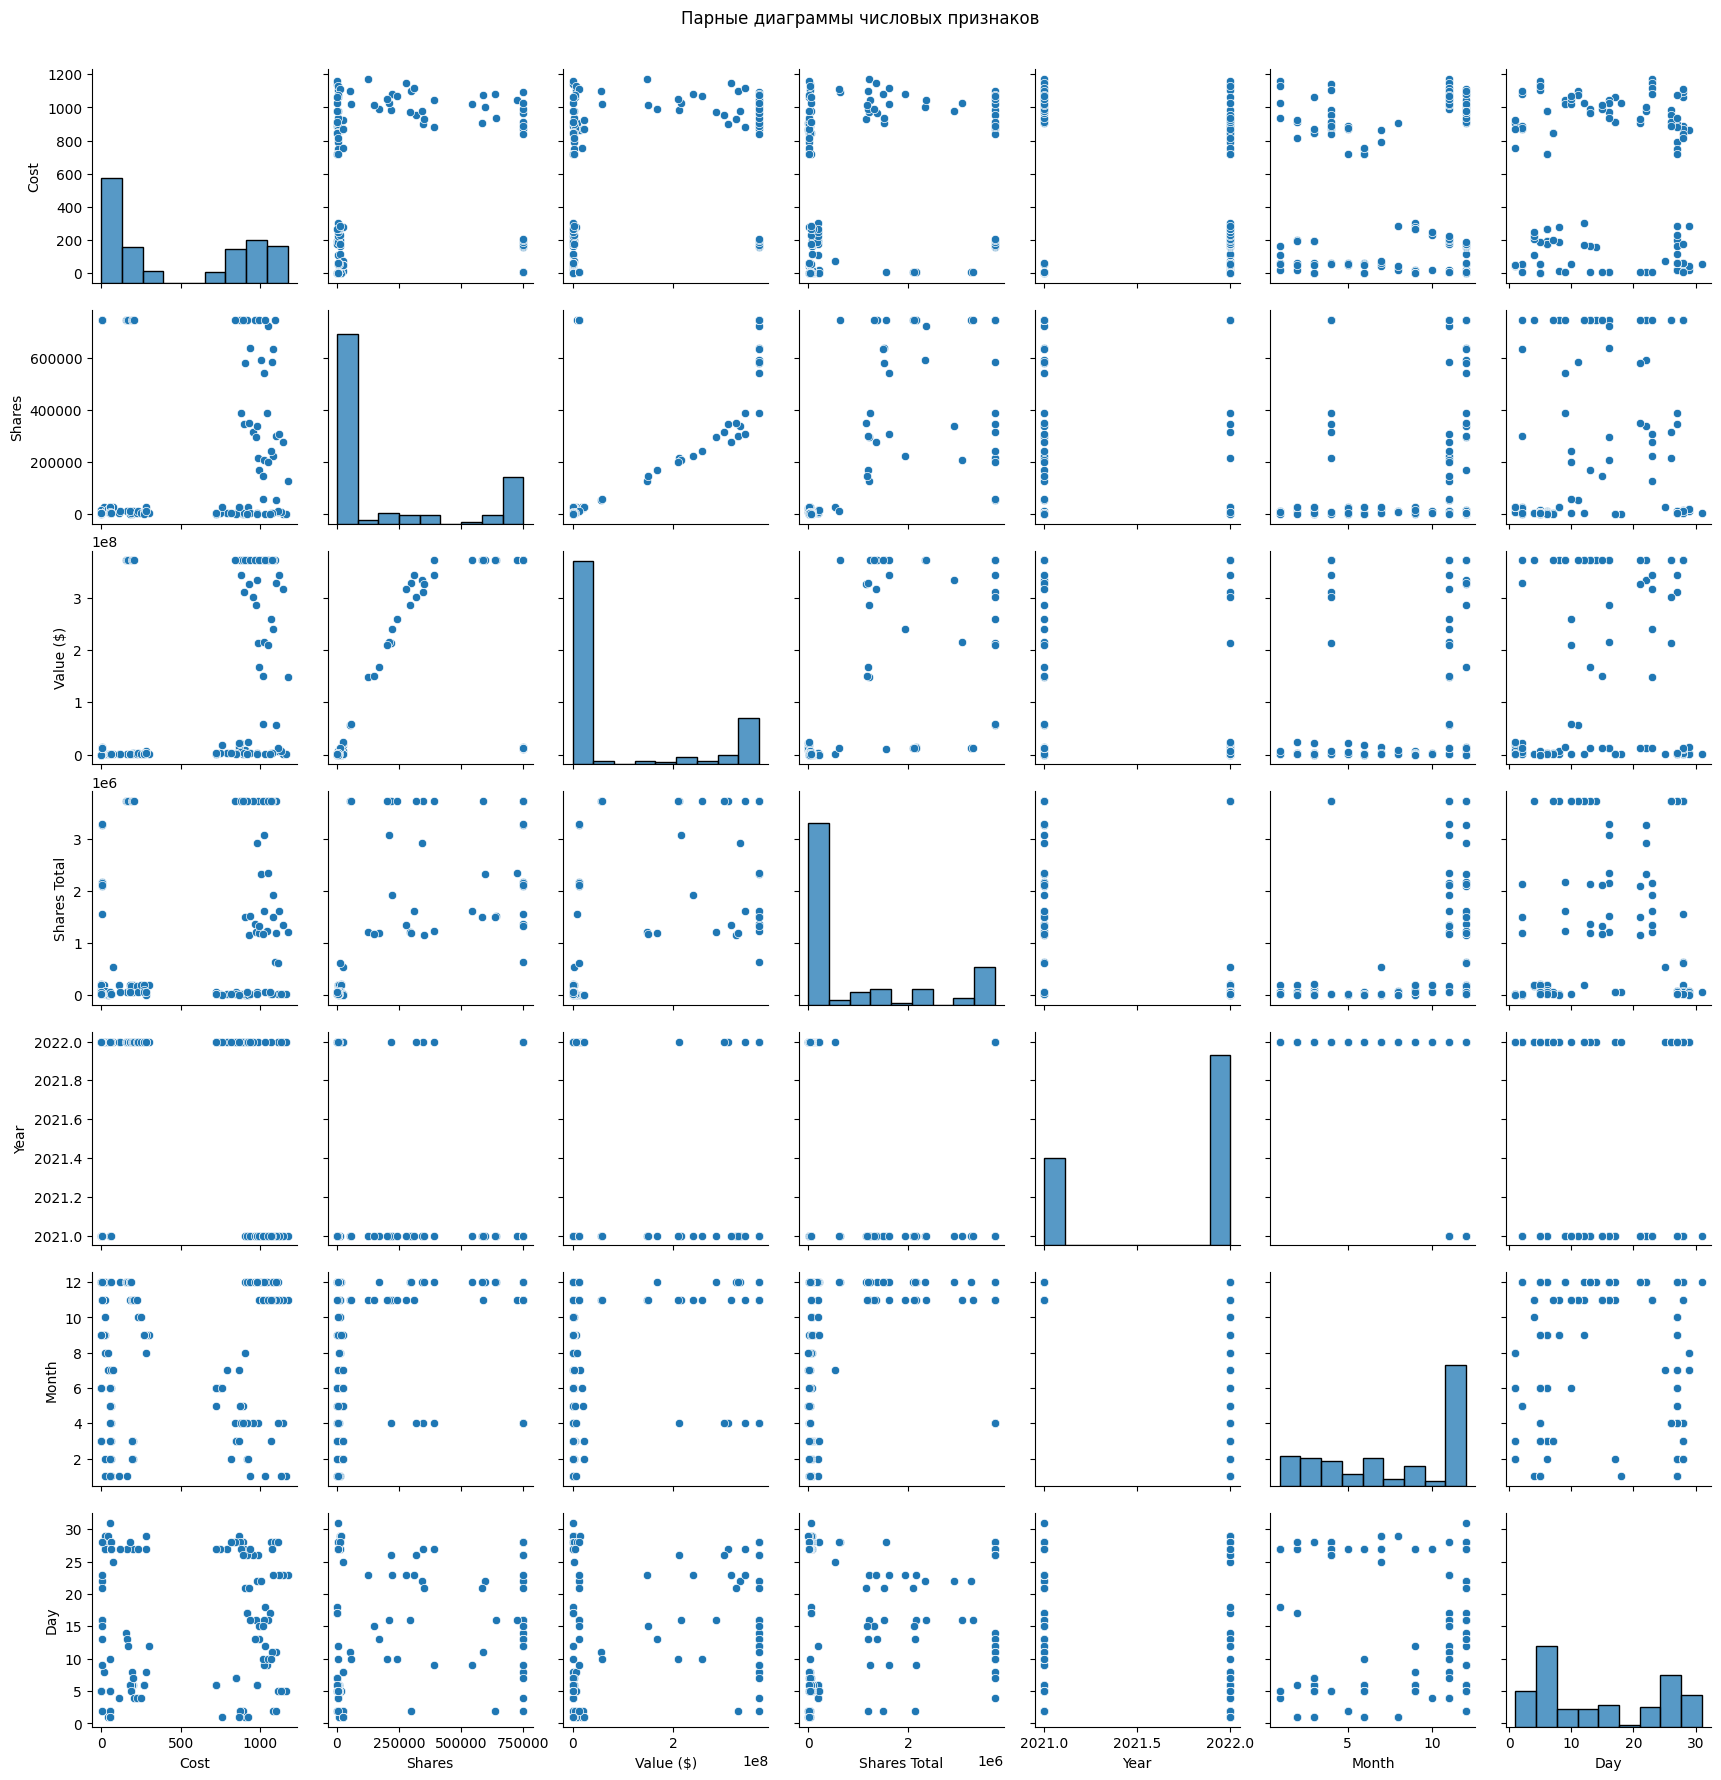

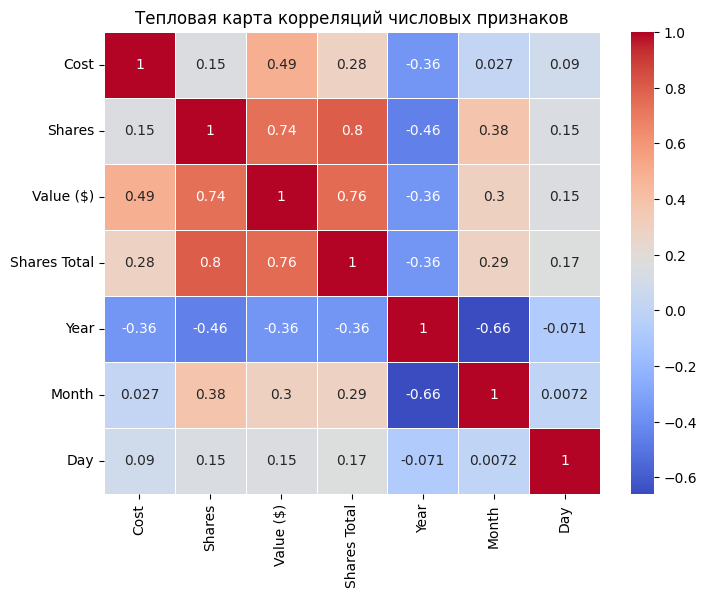

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Парные диаграммы
sns.pairplot(df[numerical_features])
plt.suptitle("Парные диаграммы числовых признаков", y=1.02)
plt.show()

# Тепловая карта корреляций
correlation_matrix: DataFrame = df[numerical_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Тепловая карта корреляций числовых признаков")
plt.show()

### Кодирование и стандартизация данных:

**Унитарное кодирование категориальных признаков (one-hot encoding)** – метод, который применяется для преобразования категориальных переменных в числовой формат. Каждая характеристика представляется в виде бинарного вектора, где для каждой категории выделяется отдельный признак (столбец) со значением 1 (True), если объект принадлежит этой категории, и 0 (False) в противном случае.

**Стандартизация данных** – это процесс преобразования признаков в наборе данных так, чтобы они имели нулевое среднее значение и единичную дисперсию. Это делается для того, чтобы привести данные к одному масштабу, что особенно важно для алгоритмов машинного обучения, которые чувствительны к масштабам признаков.

In [16]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
df_encoded: DataFrame = pd.get_dummies(df)
df_standardized: DataFrame = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)

### Понижение размерности:

**Основные методы понижения размерности:**
1. **Метод главных компонент (PCA)** – это статистический метод, который используется для уменьшения размерности данных, сохраняя при этом как можно больше информации. Он работает путем нахождения направлений (главных компонент), вдоль которых данные имеют максимальную дисперсию. Эти направления представляют собой линейные комбинации исходных признаков. PCA помогает выявить скрытые структуры в данных и уменьшить шум, что может улучшить производительность моделей машинного обучения.
2. **Неотрицательное матричное разложение (NMF)** – это метод разложения матриц, который используется для анализа неотрицательных данных. Он разлагает матрицу на две или более неотрицательных матриц, что делает его особенно полезным для задач, где данные не могут принимать отрицательные значения, например, в изображениях или текстовых данных. NMF позволяет выделять скрытые факторы или темы, что может помочь в интерпретации данных и снижении размерности.
3. **Линейный дискриминантный анализ (LDA)** – это метод, который используется как для классификации, так и для понижения размерности. Он ищет линейные комбинации признаков, которые лучше всего разделяют классы в данных. LDA максимизирует отношение между классами и минимизирует разброс внутри классов. В отличие от PCA, который не учитывает классовую информацию, LDA ориентирован на сохранение различий между классами, что делает его особенно полезным в задачах классификации.

В данном случае воспользуемся методом главных компонент (PCA).

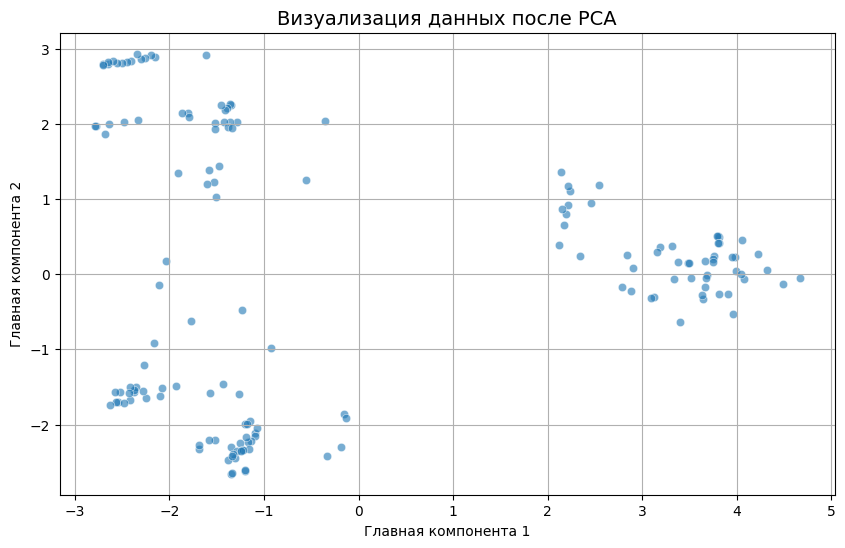

Доля объяснённой дисперсии каждой компоненты: [0.29823788 0.14095201]
Общая доля объяснённой дисперсии: 0.43918989405166786


In [17]:
from sklearn.decomposition import PCA

# Понижение размерности методом PCA
pca = PCA(n_components=2)

# Применяем PCA к стандартизированным данным
data_pca = pca.fit_transform(df_standardized)

# Преобразуем результат в DataFrame для удобства анализа
df_pca = pd.DataFrame(data_pca, columns=['Principal Component 1', 'Principal Component 2'])

# Визуализация данных после PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Principal Component 1',
    y='Principal Component 2',
    data=df_pca,
    alpha=0.6
)
plt.title('Визуализация данных после PCA', fontsize=14)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.grid(True)
plt.show()

# Объяснённая дисперсия
explained_variance = pca.explained_variance_ratio_
print("Доля объяснённой дисперсии каждой компоненты:", explained_variance)
print("Общая доля объяснённой дисперсии:", sum(explained_variance))

### Иерархическая кластеризация:

**Классификация методов иерархической кластеризации:**
1. **Агломеративные алгоритмы**: Выполняются последовательным объединением исходных элементов и соответствующим уменьшением числа кластеров (построение кластеров снизу вверх).
2. **Дивизимные алгоритмы**: Число кластеров возрастает, начиная с одного, в результате чего образуется последовательность расщепляющих групп (построение кластеров сверху вниз).

**Метод средней связи (average linkage)** – метод иерархической кластеризации, который объединяет кластеры на основе среднего расстояния между всеми парами объектов из двух кластеров. Начинается с каждого объекта как отдельного кластера, затем на каждом шаге объединяются два ближайших кластера с минимальным средним расстоянием. Этот метод устойчив к выбросам и учитывает все объекты в кластерах, но может быть вычислительно сложным для больших данных.

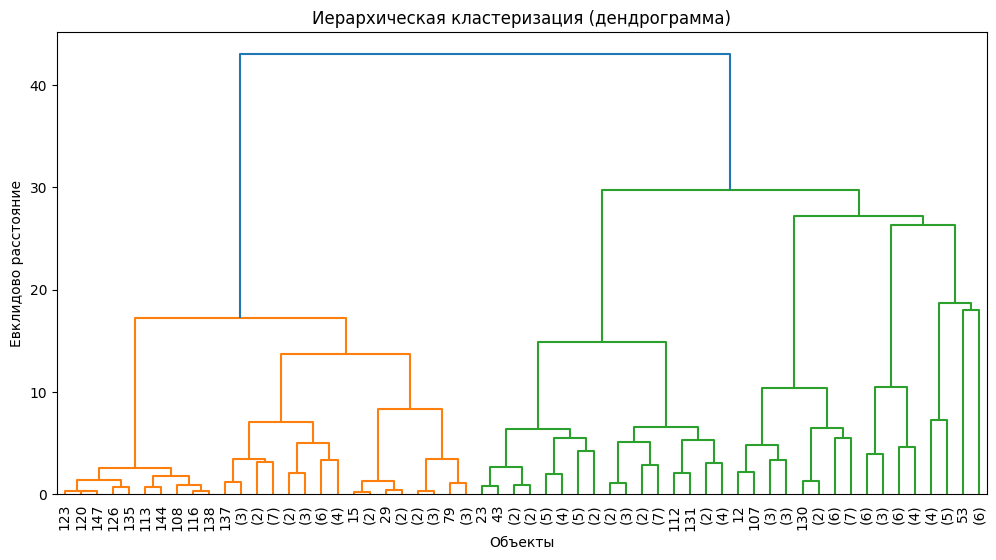

Результаты кластеризации: [3 4 2 4 2 3 2 2 3 2 2 3 3 2 2 1 1 1 3 4 2 4 3 2 3 2 2 1 1 1 3 2 2 3 2 2 3
 5 5 3 4 2 4 2 3 2 2 5 5 5 5 2 2 5 2 2 4 4 3 2 4 3 2 5 5 2 2 5 2 5 5 2 1 1
 1 2 2 1 1 1 1 1 1 4 4 4 2 2 2 3 4 4 3 2 5 5 2 2 3 5 5 2 2 3 4 4 4 3 1 1 1
 2 2 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 4 3 2 2 3 4 1 1 1 1 1 1 1 1 3 1 1 1 1
 1 1 1 1 1 1 1 1]


In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


# Выполняем кластеризацию методом "средней связи" (average linkage)
linkage_matrix = linkage(df_standardized, method='ward')

# Построение дендрограммы
plt.figure(figsize=(12, 6))
dendrogram(
    linkage_matrix,
    truncate_mode="level", # Ограничить уровни дерева для лучшей читаемости
    p=5,                   # Количество уровней для отображения
    leaf_rotation=90,
    leaf_font_size=10,
)
plt.title("Иерархическая кластеризация (дендрограмма)")
plt.xlabel("Объекты")
plt.ylabel("Евклидово расстояние")
plt.show()

# Получение результатов кластеризации с заданным порогом
result = fcluster(linkage_matrix, t=25, criterion='distance')
print("Результаты кластеризации:", result)

### Визуализация распределения кластеров:

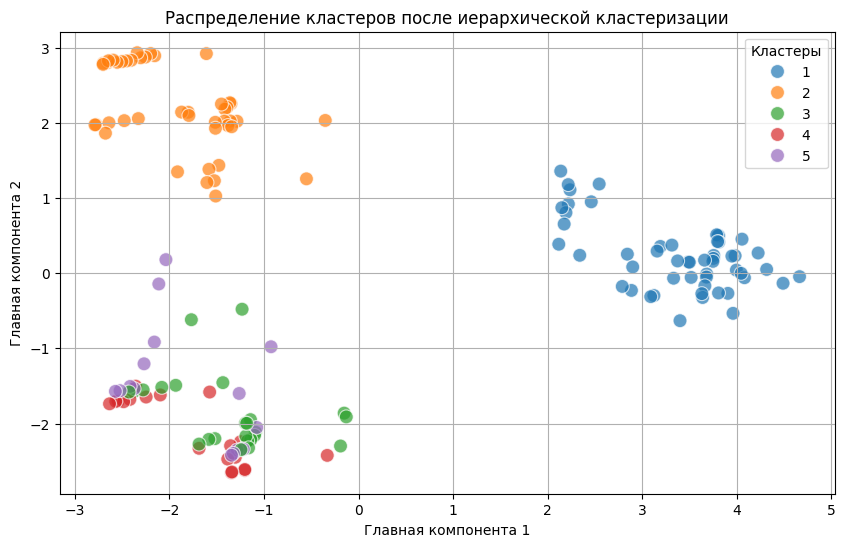

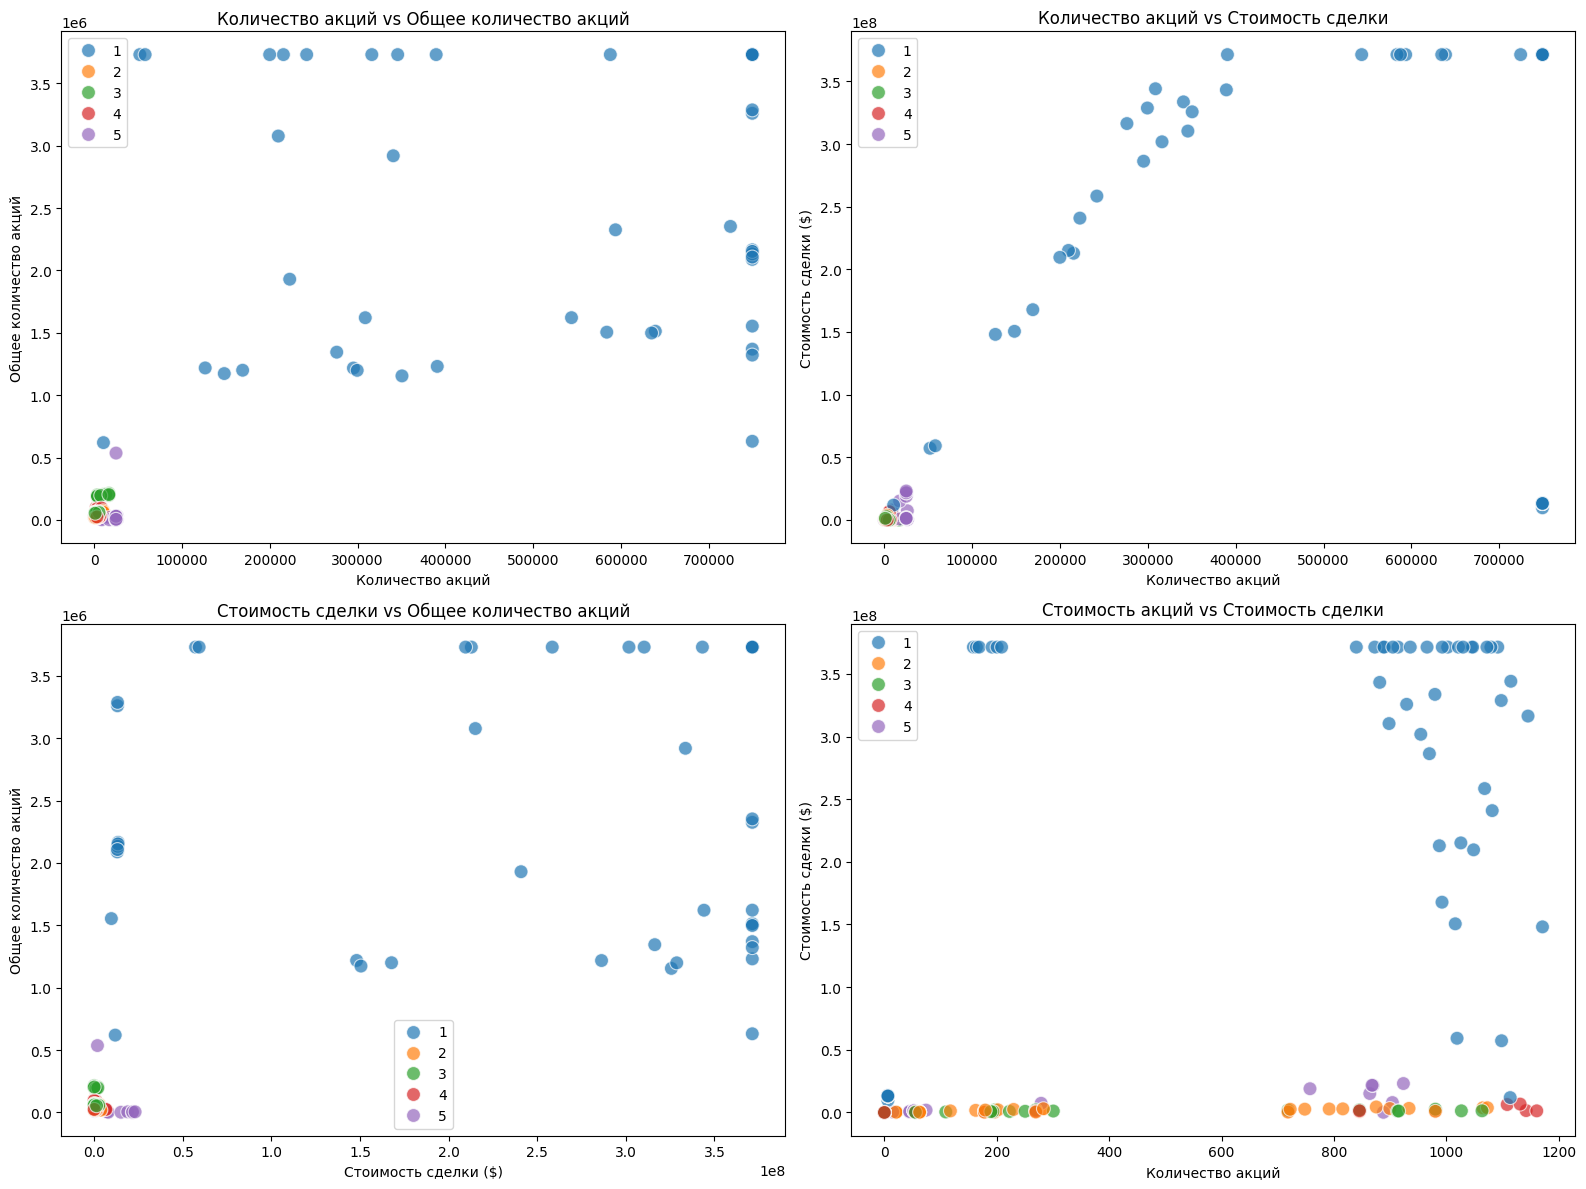

In [19]:
# Визуализация кластеров на графике рассеяния (PCA)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Principal Component 1',
    y='Principal Component 2',
    hue=result, # Классификация по кластерам
    palette='tab10',
    data=df_pca,
    alpha=0.7,
    s=100
)
plt.title('Распределение кластеров после иерархической кластеризации')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.legend(title="Кластеры")
plt.grid(True)
plt.show()

# Объединение всех графиков в одну фигуру
plt.figure(figsize=(16, 12))

# Визуализация для 'Shares' и 'Shares Total'
plt.subplot(2, 2, 1)
sns.scatterplot(
    x='Shares', 
    y='Shares Total', 
    hue=result, 
    palette='tab10',
    data=df, 
    alpha=0.7,
    s=100
)
plt.title('Количество акций vs Общее количество акций')
plt.xlabel('Количество акций')
plt.ylabel('Общее количество акций')

# Визуализация для 'Shares' и 'Value ($)'
plt.subplot(2, 2, 2)
sns.scatterplot(
    x='Shares', 
    y='Value ($)', 
    hue=result, 
    palette='tab10',
    data=df, 
    alpha=0.7,
    s=100
)
plt.title('Количество акций vs Стоимость сделки')
plt.xlabel('Количество акций')
plt.ylabel('Стоимость сделки ($)')

# Визуализация для 'Value ($)' и 'Shares Total'
plt.subplot(2, 2, 3)
sns.scatterplot(
    x='Value ($)', 
    y='Shares Total', 
    hue=result, 
    palette='tab10',
    data=df, 
    alpha=0.7,
    s=100
)
plt.title('Стоимость сделки vs Общее количество акций')
plt.xlabel('Стоимость сделки ($)')
plt.ylabel('Общее количество акций')

# Визуализация для 'Cost' и 'Value ($)'
plt.subplot(2, 2, 4)
sns.scatterplot(
    x='Cost', 
    y='Value ($)', 
    hue=result, 
    palette='tab10',
    data=df, 
    alpha=0.7,
    s=100
)
plt.title('Стоимость акций vs Стоимость сделки')
plt.xlabel('Количество акций')
plt.ylabel('Стоимость сделки ($)')

# Отображение графиков
plt.tight_layout()
plt.show()

### Неиерархическая кластеризация:

**Классификация методов неиерархической кластеризации:**
1. **Четкие алгоритмы**: Объект принадлежит только одному кластеру.
2. **Нечеткие алгоритмы**: Объект принадлежит нескольким кластерам с разной степенью принадлежности (сумма всех степеней равна 1).

**Метод K-Means** –:это алгоритм неиерархической кластеризации, который делит данные на k кластеров на основе их сходства. Он начинается с случайного выбора k центроидов и далее итеративно присваивает каждому объекту ближайший центроид, обновляя центры кластеров как средние значения объектов, принадлежащих им. Процесс продолжается до тех пор, пока центроиды не изменяются существенно.

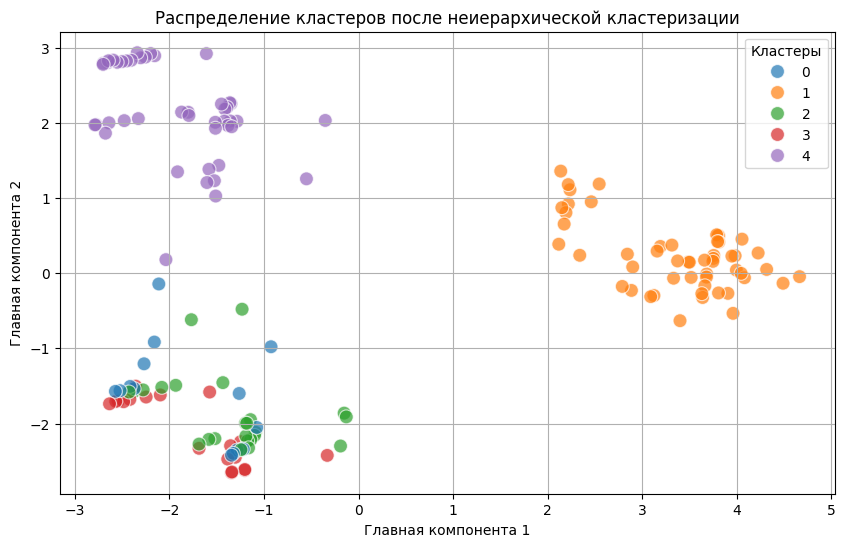

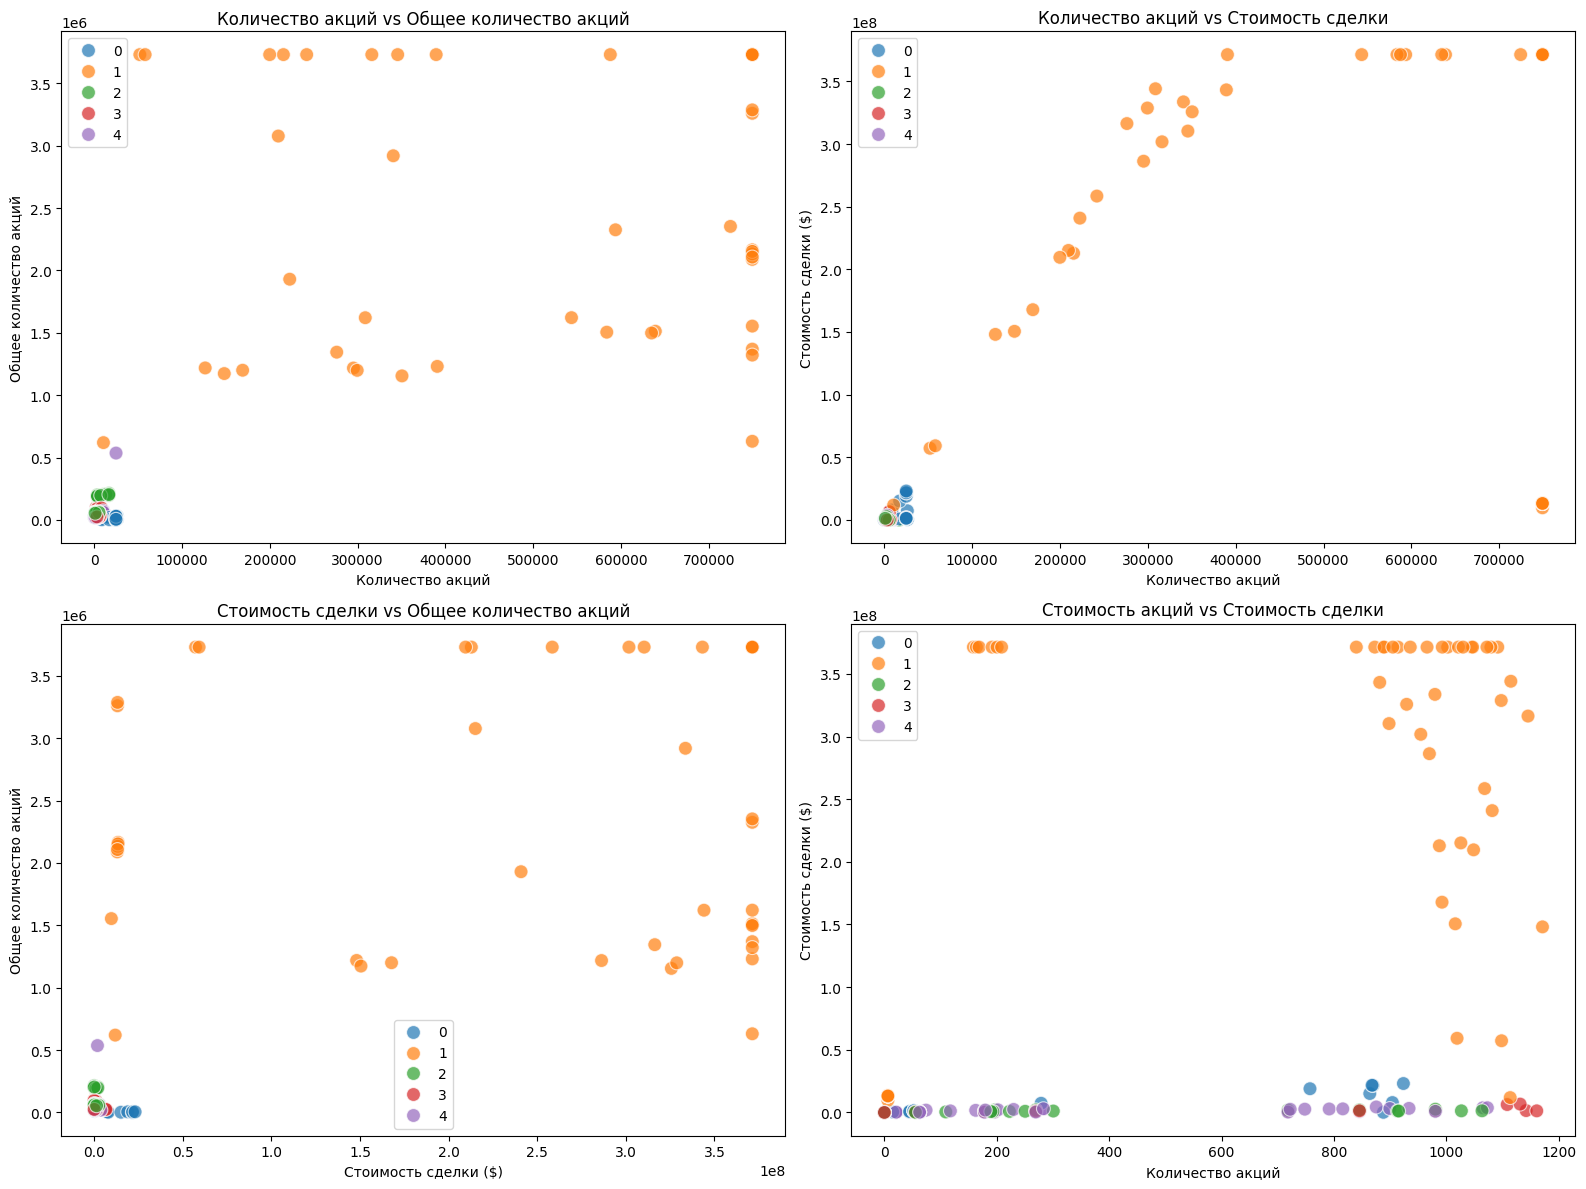

In [20]:
from sklearn.cluster import KMeans


# Обучение модели KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(df_standardized)

# Визуализация кластеров на графике рассеяния (PCA)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Principal Component 1',
    y='Principal Component 2',
    hue=labels, # Классификация по кластерам
    palette='tab10',
    data=df_pca,
    alpha=0.7,
    s=100
)
plt.title('Распределение кластеров после неиерархической кластеризации')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.legend(title="Кластеры")
plt.grid(True)
plt.show()

# Объединение всех графиков в одну фигуру
plt.figure(figsize=(16, 12))

# Визуализация для 'Shares' и 'Shares Total'
plt.subplot(2, 2, 1)
sns.scatterplot(
    x='Shares', 
    y='Shares Total', 
    hue=labels, 
    palette='tab10',
    data=df, 
    alpha=0.7,
    s=100
)
plt.title('Количество акций vs Общее количество акций')
plt.xlabel('Количество акций')
plt.ylabel('Общее количество акций')

# Визуализация для 'Shares' и 'Value ($)'
plt.subplot(2, 2, 2)
sns.scatterplot(
    x='Shares', 
    y='Value ($)', 
    hue=labels, 
    palette='tab10',
    data=df, 
    alpha=0.7,
    s=100
)
plt.title('Количество акций vs Стоимость сделки')
plt.xlabel('Количество акций')
plt.ylabel('Стоимость сделки ($)')

# Визуализация для 'Value ($)' и 'Shares Total'
plt.subplot(2, 2, 3)
sns.scatterplot(
    x='Value ($)', 
    y='Shares Total', 
    hue=labels, 
    palette='tab10',
    data=df, 
    alpha=0.7,
    s=100
)
plt.title('Стоимость сделки vs Общее количество акций')
plt.xlabel('Стоимость сделки ($)')
plt.ylabel('Общее количество акций')

# Визуализация для 'Cost' и 'Value ($)'
plt.subplot(2, 2, 4)
sns.scatterplot(
    x='Cost', 
    y='Value ($)', 
    hue=labels, 
    palette='tab10',
    data=df, 
    alpha=0.7,
    s=100
)
plt.title('Стоимость акций vs Стоимость сделки')
plt.xlabel('Количество акций')
plt.ylabel('Стоимость сделки ($)')

# Отображение графиков
plt.tight_layout()
plt.show()

### Метод локтя:

**Метод локтя** – это способ определения оптимального числа кластеров k в алгоритме K-Means. Он основывается на анализе инерции (суммы квадратов расстояний внутри кластеров).

**Принцип работы алгоритма:**
1. Вычисление инерции: Для различных значений k вычисляется инерция W(k).
2. Построение графика: Строится график зависимости инерции от числа кластеров k.
3. Поиск "локтя": На графике ищется точка, где снижение инерции начинает замедляться. Эта точка указывает на оптимальное количество кластеров.

Метод помогает избежать переобучения и обеспечивает баланс между сложностью модели и качеством кластеризации.

**Анализ полученных значений:**
- Первоначальное снижение: Инерция значительно снижается, особенно между k = 1 и k = 5.
- Замедление снижения: После k = 5 снижение становится менее выраженным.
- Аномалия на k = 6: Увеличение значения инерции при k = 6 может быть связано с особенностями данных или нестабильностью кластера.
- Локоть: Явно видимый "локоть" на графике наблюдается при k = 4 или k = 5. Эти значения можно рассматривать как оптимальное количество кластеров.

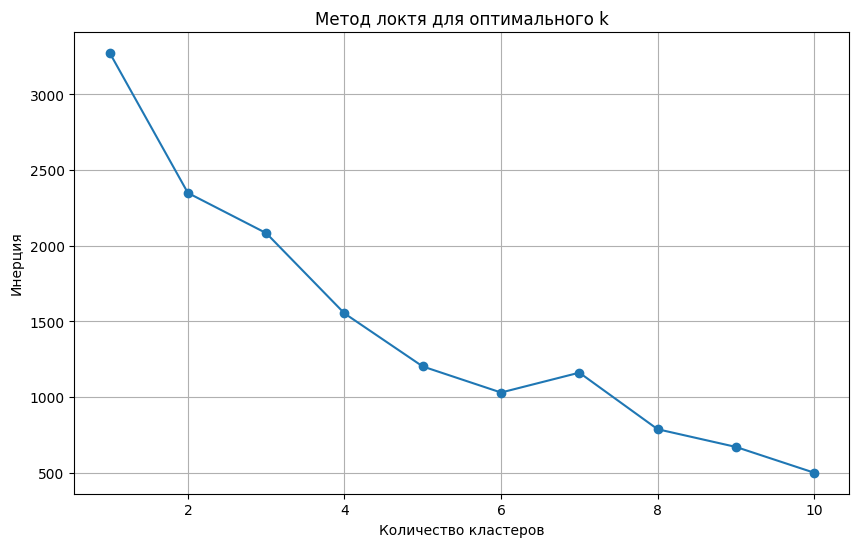

In [21]:
inertias = []
clusters_range = range(1, 11)
for k in clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_standardized)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(clusters_range, inertias, marker='o')
plt.title('Метод локтя для оптимального k')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.grid(True)
plt.show()

### Коэффициент силуэта:

**Коэффициент силуэта** – это метрика для оценки качества кластеризации, варьирующаяся от -1 до 1:
- 1: Объект хорошо кластеризован, далеко от других кластеров.
- 0: Объект на границе между кластерами.
- -1: Объект, вероятно, неправильно классифицирован.

Он рассчитывается по формуле: `s(i) = b(i) - a(i) / max(a(i), b(i))`, где `a(i)` – среднее расстояние до объектов в том же кластере, а `b(i)` – минимальное среднее расстояние до объектов в ближайшем кластере. Высокие значения указывают на хорошую кластеризацию, низкие – на проблемы с классификацией.

**Анализ полученных значений:**
- Рост до k = 6: Значения коэффициента силуэта увеличиваются до k = 6, достигая 0.5076. Это указывает, что кластеризация при k = 6 лучше других.
- Максимум на k = 8: Максимальное значение 0.5083 достигается при k = 8. Однако разница между k = 6 и k = 8 минимальна.
- Снижение после k = 8: Коэффициент силуэта остаётся на высоком уровне, но немного снижается.

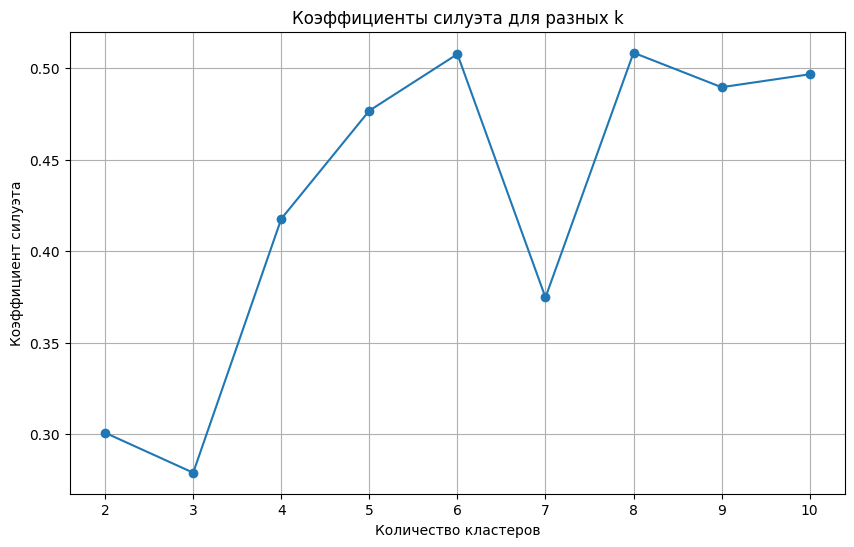

In [22]:
from sklearn.metrics import silhouette_score


silhouette_scores = []
for k in clusters_range[1:]: 
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_standardized)
    score = silhouette_score(df_standardized, labels, random_state=42)
    silhouette_scores.append(score)

# Построение диаграммы значений силуэта
plt.figure(figsize=(10, 6))
plt.plot(clusters_range[1:], silhouette_scores, marker='o')
plt.title('Коэффициенты силуэта для разных k')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.grid(True)
plt.show()

### Иерархическая кластеризация на основе полученных оценок:

**Количество кластеров:**
На основании анализа инерции и коэффициента силуэта, оптимальным количеством кластеров можно считать 5. Это значение обеспечивает хорошее качество кластеризации с минимальным уровнем инерции и приемлемым значением коэффициента силуэта.

**Анализ полученного значения:**
Значение среднего коэффициент силуэта = 0.472 говорит о том, что качество кластеризации находится на среднем уровне. Объекты в кластерах не слишком плохо разделены, но и не идеально. Возможно, некоторые объекты находятся на границе между кластерами, что может вызывать сомнения в разбивке на кластеры.

Средний коэффициент силуэта: 0.472


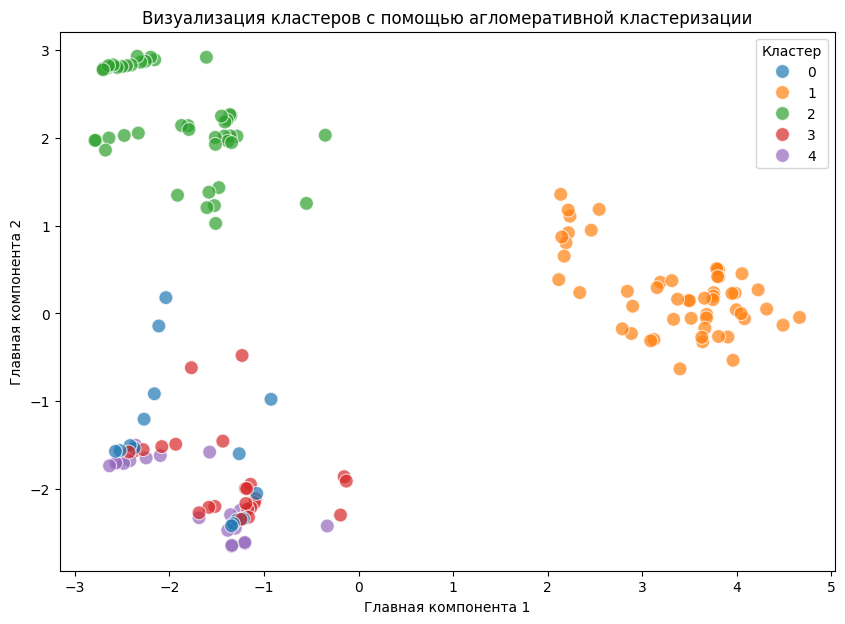

In [23]:
from sklearn.cluster import AgglomerativeClustering


# Агломеративная кластеризация
agg_cluster = AgglomerativeClustering(n_clusters=5) # Выбираем 5 кластеров
labels_agg = agg_cluster.fit_predict(df_standardized)

# Оценка качества кластеризации
silhouette_avg_agg = silhouette_score(df_standardized, labels_agg, random_state=42) # Коэффициент силуэта
print(f'Средний коэффициент силуэта: {silhouette_avg_agg:.3f}')

# Визуализация кластеров на графике
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='Principal Component 1',
    y='Principal Component 2',
    hue=labels_agg, # Классификация по кластерам
    palette='tab10',
    data=df_pca,
    alpha=0.7,
    s=100
)
plt.title('Визуализация кластеров с помощью агломеративной кластеризации')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.legend(title='Кластер', loc='upper right')
plt.show()

### Неиерархическая кластеризация на основе полученных оценок:

**Количество кластеров:**
На основании анализа инерции и коэффициента силуэта, оптимальным количеством кластеров можно считать 5. Это значение обеспечивает хорошее качество кластеризации с минимальным уровнем инерции и приемлемым значением коэффициента силуэта.

**Анализ полученного значения:**
В случае с KMeans, коэффициент силуэта составил 0.477, что немного выше, чем у агломеративной кластеризации. Это также подтверждает, что KMeans может лучше справляться с разделением объектов, чем агломеративная кластеризация, хотя различия не слишком значительные.

Средний коэффициент силуэта: 0.477


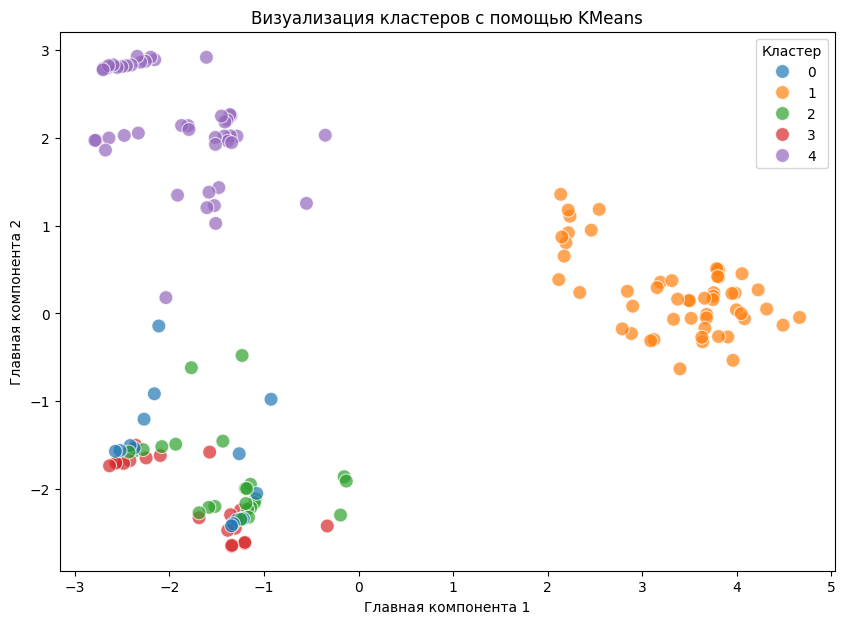

In [24]:
# Кластеризация KMeans
kmeans = KMeans(n_clusters=5, random_state=42) # Выбираем 5 кластеров
labels_kmeans = kmeans.fit_predict(df_standardized)

# Оценка качества кластеризации
silhouette_avg_agg = silhouette_score(df_standardized, labels_kmeans, random_state=42) # Коэффициент силуэта
print(f'Средний коэффициент силуэта: {silhouette_avg_agg:.3f}')

# Визуализация кластеров на графике
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='Principal Component 1',
    y='Principal Component 2',
    hue=labels_kmeans, # Классификация по кластерам
    palette='tab10',
    data=df_pca,
    alpha=0.7,
    s=100
)
plt.title('Визуализация кластеров с помощью KMeans')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.legend(title='Кластер', loc='upper right')
plt.show()

### Вывод:

Оба метода показывают схожие результаты в контексте качества кластеризации, с небольшим преимуществом у KMeans, что может быть связано с его более явной и фиксированной структурой кластеров. Однако, учитывая, что коэффициент силуэта в обоих случаях находится на уровне около 0.47, можно сделать вывод, что кластеризация имеет среднее качество и существует некоторое наложение между кластерами, что требует дополнительного анализа.